In [1]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import h5py
from numpy import ma as ma
from types import SimpleNamespace
# from crewmate.utils import quick_wigner, find_highest_populated_state
from scipy.optimize import curve_fit
from helpers import *

### Helpers

In [2]:
def compute_max_Fq(alpha):
    cdim = 30
    psi = (coherent(cdim, 0) + coherent(cdim, alpha)).unit()
    a = destroy(cdim)
    return 4 * (
        np.abs(np.array(psi.dag() * (a.dag()+a)*(a.dag()+a) * psi)[0][0]) -
        np.abs(np.array(psi.dag() * (a.dag()+a) * psi)[0][0]) ** 2
    )

# Numerical solution without loss, ideal case

def ideal_numerical(alpha, c=0.5, D=np.linspace(0, 2, 100)):
    cdim = 30
    cav_init = (
        np.sqrt(c) * coherent(cdim, 0) +
        np.sqrt(1-c) * coherent(cdim, alpha)
    ).unit()

    data = np.zeros(len(D))
    for i in range(len(D)):
        cav_final = displace(cdim, 1j*D[i]) * cav_init
        data[i] = np.abs((cav_final.dag()*cav_init)[0, 0])**2

    return data

In [3]:
d_list = np.linspace(0, 2, 50)

THRESHOLDS = {
    '2023-09-25': -0.00014956578372339103,
    '2023-09-26': -0.00014956578372339103,
    '2023-09-27': -0.00014956578372339103,
    '2023-09-28': -0.00014956578372339103,
    # New
    '2023-11-07': -3.8509558368547627e-05,
    '2023-11-08': -3.8509558368547627e-05,
    '2023-11-13': -3.4765634935704135e-05,
    '2023-11-14': -3.4765634935704135e-05,
    '2023-11-15': -3.4765634935704135e-05,
    '2023-11-16': -3.4765634935704135e-05,
    '2023-12-06': -3.9836266556996435e-05,
}

# Order of the polynomial fit for different alpha
POLYFIT_ORDER = {
    '0.5': 4,
    '0.75': 4,
    '1': 4,
    '1.25': 5,#5,
    '1.5': 5, #5,
    '1.6': 5,
    '1.75': 5,
    '2': 12, #6,
}

POLYFIT_ORDER_h = {
    '0.5': 4,
    '0.75': 4,
    '1': 4,
    '1.25': 5,
    '1.5': 5,
    '1.6': 5,
    '1.75': 5,
    '2': 12, #6,
    '2.1': 6,
    '2.2': 6,
    '2.3': 6,
    '2.4': 6,
    '2.5': 6
}

# MEASURED_SQL_v = {
#     '0.5': 2.579,  # old: 3.45
#     '0.75': 2.495,
#     '1': 2.659,  # old: 3.21
#     '1.25': 2.476,
#     '1.5': 2.445,  # old: 3.392
#     '1.6': 2.584,
#     '1.75': 2.339,
#     '2': 2.309,  # old: 3.309
#     '2.1': 4,
#     '2.2': 4,
#     '2.3': 4,
#     '2.4': 4,
#     '2.5': 2.487,  # old: 3.209

# }

MEASURED_SQL_v = {
    '0.5': 2.855115994725871,
    '0.75': 2.5133305044873073,
    '1': 2.604524115988589,
    '1.25': 2.467927028719953,
    '1.5': 2.6534278007991947,
    '1.6': 2.5846578127331004,
    '1.75': 2.3425355322141153,
    '2': 2.5866561293879027,
    # '2.1': 
    # '2.2': 
    # '2.3': 
    # '2.4': 
    # '2.5': 
}


# MEASURED_SQL_v = np.mean([MEASURED_SQL_v[i] for i in MEASURED_SQL_v])

# Amplitude estimation

## Quantum vs classical


2.347934574917125


/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1069: ComplexWarning: Casting complex values to real discards the imaginary part
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1090: ComplexWarning: Casting complex values to real discards the imaginary part
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:1097: ComplexWarning: Casting complex values to real discards the imaginary part
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n



0.7979396793269946


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)



10.416742711565057


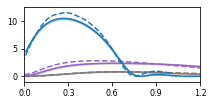

In [4]:
data_list = {
    'c2': load_experimental_data('ae/data/2023-11-13_c2.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    'h2': load_experimental_data('ae/data/2023-11-21_alpha2h.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-12-09_alpha2_d0j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
}

sim_list = {
    '2': 'ae/sim/g_0_plus_alpha2_all.npz',
    'c2': 'ae/sim/g_alpha1327_all.npz',
    'h2': 'ae/sim/g_0_plus_alpha2_all_h.npz',
}

colors = {
    # 'c2': ['tab:purple', 'tab:pink'],
    # '2': ['tab:blue', 'tab:cyan'],
    'c2': ['tab:purple', 'tab:purple'],
    '2': ['tab:blue', 'tab:blue'],
    'h2': ['tab:gray', 'tab:brown']
}

# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(8*cm, 3.5*cm))

for name in list(data_list.keys()):
    data = data_list[name]
    pe = data.y
    phase = data.x

    up_lim = 1.6  # if float(alpha) > 1 else np.max(data.x) - 0.1
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    if name[0] == 'c':
        order = 5
    elif name[0] == 'h':
        order = 6
    elif name == '2':
        order = 11
    else:
        order = POLYFIT_ORDER[name]
    # Data
    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])

    # Simulation
    if not (name in sim_list):
        continue
    sim = np.load(sim_list[name], 'r')
    phase_sim = sim['x']
    pe_sim = sim['probability_sim']
    if name[0] == 'h': phase_sim = phase_sim* 1j*1j*1j
    x_sim = phase_sim[phase_sim <= max(x)]
    y_sim = pe_sim[phase_sim <= max(x)]
    FI_sim = compute_FI(y_sim, x_sim[1]-x_sim[0])

    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Add plots
    if colors[name]:
        col = colors[name]
    else:
        col = [None, None]

    if name[0] == '2': lab = 'v ' + name_scs(2) #+ txt_ket(0) + '+' + txt_ket(r"\alpha = 2")
    elif name[0] == 'c': lab = txt_ket(r'\alpha='+str(COH_MAP['2'])) #'classical'
    elif name[0] == 'h': lab = 'h ' + name_scs(2) #+ txt_ket(0) + '+' + txt_ket(r"\alpha = 2")
    plt.plot(x_sim[x_sim<1.3], FI_sim[x_sim<1.3], '--', markersize=3, color=col[1])
    plt.plot(x[x<1.3], FI_data[x<1.3], color=col[0], label=lab)
    print(max(FI_data[x<0.6]))
    plt.fill_between(x[x<1.3], mu[x<1.3]-sigma[x<1.3], mu[x<1.3]+sigma[x<1.3], color=col[0], alpha=0.3)

plt.xlim([0, 1.2])
plt.ylim([-1, 12.5])
# ax0.set_ylim([0,2])
# ax0.set_title("Fisher Information for $n = 1$")
# ax0.set_xlabel("Displacement")
# ax0.set_ylabel("Fisher Information")
# plt.legend(loc='upper right', fontsize=8)
tick_start = 0
tick_end = 1.5
tick_step = 0.3
plt.xticks(np.arange(tick_start, tick_end, tick_step))
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('fig4c.pdf')


m, a, b, mx = extract_FI_params(x, y_fit, MEASURED_SQL_v['2'])

### Offset


10.416742711565057



9.356546017358859



10.071104688372914


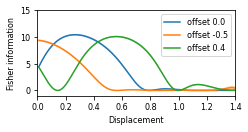

In [5]:
# alpha2_offsets = {
#     '0': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
#     # '0.2': load_experimental_data('ae/data/2023-11-16_alpha2_d0j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
#     '0.4': load_experimental_data('ae/data/2023-11-16_alpha2_d04j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
#     # '-0.15': load_experimental_data('ae/data/2023-11-16_alpha2_dm015j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
#     '-0.308': load_experimental_data('ae/data/2023-11-16_alpha2_dm0308j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
# }
alpha2_offsets = {
    # '0': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '-0.2': load_experimental_data('ae/data/2023-11-14_alpha2v_om02.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '-0.308': load_experimental_data('ae/data/2023-11-14_alpha2v_om0308.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '-0.4': load_experimental_data('ae/data/2023-11-14_alpha2v_om04.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '0': load_experimental_data('ae/data/2023-11-16_alpha2_d0j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '0.2': load_experimental_data('ae/data/2023-11-16_alpha2_d02j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '0.4': load_experimental_data('ae/data/2023-11-16_alpha2_d04j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '0.0': load_experimental_data('ae/data/2023-12-09_alpha2_d0j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    # '-0.15': load_experimental_data('ae/data/2023-11-16_alpha2_dm015j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '-0.308': load_experimental_data('ae/data/2023-11-16_alpha2_dm0308j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    
    # '0.0': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '-0.4': load_experimental_data('ae/data/2023-12-08_alpha2_dm04j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    '-0.5': load_experimental_data('ae/data/2023-12-09_alpha2_dm05j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    # '-0.6': load_experimental_data('ae/data/2023-12-08_alpha2_dm06j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    # '-0.7': load_experimental_data('ae/data/2023-12-08_alpha2_dm07j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    '0.4': load_experimental_data('ae/data/2023-12-10_alpha2_d04j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
}
offset_data = alpha2_offsets
# MEASURED_SQL = MEASURED_SQL_v['1.6']

# alphas = list(offset_data.keys())
# np_alphas = np.array(alphas, dtype='float')

fig = make_figure()
ax0 = fig.add_subplot(111)

for offset in offset_data:
    data = offset_data[offset]
    pe = data.y
    phase = data.x

    up_lim = 1.6  # if float(alpha) > 1 else np.max(data.x) - 0.1
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    if offset == '0.0': order = 11 #POLYFIT_ORDER['2']
    elif offset == '0.2': order = 10 # 15
    elif offset == '0.4': order = 10#15
    elif offset == '-0.15': order = 10 #15
    elif offset == '-0.308': order = 10# 15
    elif offset == '-0.4': order = 10
    elif offset == '-0.5': order = 11# 15
    else: 4

    # Data fit
    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])

    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    ax0.plot(x, FI_data, label=f'offset {offset}')
    ax0.fill_between(x, mu-sigma, mu+sigma, alpha=0.3)
    print(max(FI_data[x<0.6]))

ax0.set_xlabel('Displacement')
ax0.set_ylabel('Fisher information')
ax0.set_xlim([0,1.4])
ax0.set_ylim([-1,15])
# ax0.set_ylim([9,10])
ax0.legend()
plt.savefig('FI_vs_amp_offset.pdf')


10.696361886704747



9.340765061614423



10.011516579370635


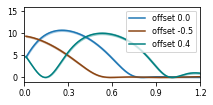

In [6]:
# alpha2_offsets = {
#     '0': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
#     # '0.2': load_experimental_data('ae/data/2023-11-16_alpha2_d0j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
#     '0.4': load_experimental_data('ae/data/2023-11-16_alpha2_d04j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
#     # '-0.15': load_experimental_data('ae/data/2023-11-16_alpha2_dm015j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
#     '-0.308': load_experimental_data('ae/data/2023-11-16_alpha2_dm0308j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
# }
alpha2_offsets = {
    # '0': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '-0.2': load_experimental_data('ae/data/2023-11-14_alpha2v_om02.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '-0.308': load_experimental_data('ae/data/2023-11-14_alpha2v_om0308.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '-0.4': load_experimental_data('ae/data/2023-11-14_alpha2v_om04.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '0': load_experimental_data('ae/data/2023-11-16_alpha2_d0j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '0.2': load_experimental_data('ae/data/2023-11-16_alpha2_d02j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '0.4': load_experimental_data('ae/data/2023-11-16_alpha2_d04j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '0.0': load_experimental_data('ae/data/2023-12-09_alpha2_d0j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    # '-0.15': load_experimental_data('ae/data/2023-11-16_alpha2_dm015j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '-0.308': load_experimental_data('ae/data/2023-11-16_alpha2_dm0308j.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    # '0.0': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '-0.4': load_experimental_data('ae/data/2023-12-08_alpha2_dm04j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    '-0.5': load_experimental_data('ae/data/2023-12-09_alpha2_dm05j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    # '-0.6': load_experimental_data('ae/data/2023-12-08_alpha2_dm06j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    # '-0.7': load_experimental_data('ae/data/2023-12-08_alpha2_dm07j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    '0.4': load_experimental_data('ae/data/2023-12-10_alpha2_d04j.h5', THRESHOLDS['2023-12-06'], amplitude=True),
}
offset_data = alpha2_offsets
# MEASURED_SQL = MEASURED_SQL_v['1.6']
# alphas = list(offset_data.keys())
# np_alphas = np.array(alphas, dtype='float')
cm = 0.393701
# fig, ax0 = plt.subplots(figsize =(3.5*cm, 3.5*cm))

colorset = {'0.0': 'tab:blue',
            '-0.5': 'saddlebrown',
            '0.4': 'teal'}
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))
for offset in offset_data:
    data = offset_data[offset]
    pe = data.y
    phase = data.x
    up_lim = 1.6  # if float(alpha) > 1 else np.max(data.x) - 0.1
    x_dense = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)
    if offset == '0.0': order = 12 #POLYFIT_ORDER['2']
    elif offset == '0.2': order = 10 # 15
    elif offset == '0.4': order = 12#15
    elif offset == '-0.15': order = 10 #15
    elif offset == '-0.308': order = 10# 15
    elif offset == '-0.4': order = 12
    elif offset == '-0.5': order = 12# 15
    else: 4
    # Data fit
    data_fit = np.polyfit(phase[phase <= up_lim], pe[phase <= up_lim], order)
    x = x_dense[(x_dense <= up_lim)]
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)
    # print(mu-sigma)
    # print(mu+sigma)
    # print((mu-sigma)-(mu+sigma))
    ax0.plot(x[x<1.2], FI_data[x<1.2],color=colorset[offset], label=f'offset {offset}')
    ax0.fill_between(x[x<1.2], mu[x<1.2]-sigma[x<1.2], mu[x<1.2]+sigma[x<1.2], color=colorset[offset],alpha=0.3)
    print(max(FI_data[x<0.6]))
# ax0.set_xlabel('Displacement')
# ax0.set_ylabel('Fisher information')
ax0.set_xlim([0,1.2])
ax0.set_ylim([-1,16])
# ax0.set_ylim([9,10])
ax0.legend()
tick_start = 0
tick_end = 1.5
tick_step = 0.3
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))
plt.savefig('sfig3b.pdf')

### Different states

## Photon number scaling

### SCS vs n

(0.0, 12.5)

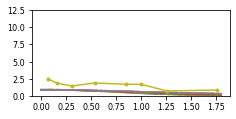

In [7]:
alpha_data_h = {
    '0.5': load_experimental_data('ae/data/2023-11-17_alpha05h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-17_alpha075h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-17_alpha1h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-17_alpha125h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-17_alpha15h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-17_alpha15h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-17_alpha175h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-17_alpha2h.h5', THRESHOLDS['2023-11-16'], amplitude=True),
}

alpha_sim = {
    '0.5': 'ae/sim/g_0_plus_alpha05_all.npz',
    '0.75': 'ae/sim/g_0_plus_alpha075_all.npz',
    '1': 'ae/sim/g_0_plus_alpha1_all.npz',
    '1.25': 'ae/sim/g_0_plus_alpha125_all.npz',
    '1.5': 'ae/sim/g_0_plus_alpha15_all.npz',
    '1.6': 'ae/sim/g_0_plus_alpha16_all.npz',
    '1.75': 'ae/sim/g_0_plus_alpha175_all.npz',
    '2': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.1': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.2': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.3': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.4': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.5': 'ae/sim/g_0_plus_alpha2_all.npz',
    # '2.25': 'ae/sim/g_0_plus_alpha225_pm.npz',
    # '2.5': 'ae/sim/g_0_plus_alpha25_pm.npz',
}

fig = make_figure()
ax0 = fig.add_subplot(111)

alpha_data = alpha_data_h

alphas = list(alpha_data.keys())
np_alphas = np.array(alphas, dtype='float')


result_max_h = []
for offset in alpha_data_h:
    data = alpha_data_h[offset]
    up_lim = 1.6 #np.max(data.x) # 0.1 if (np.max(data.x) < 1.6) else 1.6
    x_dense = np.linspace(np.max([np.min(data.x), 0.01]), up_lim, 2000) #np.linspace(min(d_list), up_lim, 2000)
    # Data fit
    data_fit = np.polyfit(data.x[data.x<=up_lim], data.y[data.x<=up_lim], POLYFIT_ORDER_h[offset])
    # Experimental FI
    x = x_dense[(x_dense <= up_lim) & (x_dense > 0.0)]
    y_fit = np.poly1d(data_fit)(x)
    plt.plot(data.x, data.y)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    result_max_h.append(FI_data.max())
 


n = [compute_photon_number(v) for v in np_alphas]


# # Fisher information plot
ax0.plot(n, result_max_h, '.-', label="Measured FI max")
ax0.set_ylim(0,12.5)



In [8]:
def compute_many_FI_error_offset(data, x_fit, fit_order, up_lim, n_boot=100):
    x_len = len(data.x)

    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    
    for i in tqdm(range(x_len)):
        # First measurement, g
        _, _, mu_boot_g[:, i] = bootstrap(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)

    # Compute Fisher information
    idx = data.x < up_lim
    x = x_fit
    FIs = np.zeros([n_boot, len(x)])
    offset_data_array =[]
    for i in range(n_boot):
        
        mu = (1-mu_boot_g[i, :]) * mu_boot_gvac[i, :]

        data_fit = np.polyfit(data.x[idx], mu[idx], fit_order)

        # Fisher information
        y_fit = np.poly1d(data_fit)(x)
        FIs[i, :] = compute_FI(y_fit, x[1] - x[0])

        # index = np.argmax(FIs[i,:])
        index = np.argmax(FIs[i, x_fit<1])
        # print(index)
        index_offset = np.argmin(np.abs(data.x-x_fit[index]))
        offset_data_array.append(data.x[index_offset])

    print(offset_data_array)    
    var_offset = np.var(offset_data_array)   
  
    # Observed FI
    data_fit = np.polyfit(data.x[idx], data.y[idx], fit_order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])

    # Account for std estimation bias by shifting the distribution to the observed mean
    FI_mu = np.mean(FIs, axis=0)
    FIs += FI_data - FI_mu
    FI_sigma = np.std(FIs, axis=0)

    return FI_mu, FI_sigma, np.sqrt(var_offset)


[0.5199999883770943, 0.4999999888241291, 0.4399999901652336, 0.5199999883770943, 0.47999998927116394, 0.4999999888241291, 0.47999998927116394, 0.5199999883770943, 0.4599999897181988, 0.5199999883770943, 0.5199999883770943, 0.6199999861419201, 0.4999999888241291, 0.5199999883770943, 0.5399999879300594, 0.4999999888241291, 0.5199999883770943, 0.4999999888241291, 0.47999998927116394, 0.47999998927116394, 0.5199999883770943, 0.4999999888241291, 0.5199999883770943, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.47999998927116394, 0.47999998927116394, 0.5199999883770943, 0.4599999897181988, 0.5199999883770943, 0.5199999883770943, 0.4999999888241291, 0.47999998927116394, 0.4999999888241291, 0.5399999879300594, 0.4999999888241291, 0.4999999888241291, 0.47999998927116394, 0.4999999888241291, 0.47999998927116394, 0.47999998927116394, 0.4999999888241291, 0.5199999883770943, 0.5199999883770943, 0.47999998927116394, 0.5399999879300594, 0.4999999888241291, 0.5399999879300594, 0.45999


[0.4999999888241291, 0.5599999874830246, 0.5199999883770943, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.5399999879300594, 0.47999998927116394, 0.4999999888241291, 0.47999998927116394, 0.5199999883770943, 0.5199999883770943, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.5199999883770943, 0.47999998927116394, 0.5199999883770943, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.4999999888241291, 0.5199999883770943, 0.4999999888241291, 0.47999998927116394, 0.47999998927116394, 0.5199999883770943, 0.5199999883770943, 0.47999998927116394, 0.5399999879300594, 0.4999999888241291, 0.4999999888241291, 0.5199999883770943, 0.47999998927116394, 0.5199999883770943, 0.4999999888241291, 0.5399999879300594, 0.4999999888241291, 0.5199999883770943, 0.4999999888241291, 0.4999999888241291, 0.5199999883770943, 0.5199999883770943, 0.47999998927116394, 0.47999998


[0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.5399999879300594, 0.5399999879300594, 0.5199999883770943, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5599999874830246, 0.5399999879300594, 0.5399999879300594, 0.5399999879300594, 0.5199999883770943, 0.5599999874830246, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5599999874830246, 0.5199999883770943, 0.5399999879300594, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.5399999879300594, 0.5399999879300594, 0.5399999879300594, 0.5199999883770943, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.5199999883770943, 0.5199999883770943, 0.5199999883770943, 0.5399999879300594, 0.4999999888241291, 0.4999999888241291, 0.5199999883770943, 0.5399999879300594

/Users/panxiaozhou/Documents/GitHub/Metrology_project/protocol_simulation/panda4/helpers.py:55: RuntimeWarning: divide by zero encountered in true_divide
  return (dy**2 / (y) + dy**2 / (1-y))



[0.3999999910593033, 0.35999999195337296, 0.3399999924004078, 0.4399999901652336, 0.3799999915063381, 0.3999999910593033, 0.41999999061226845, 0.3799999915063381, 0.5399999879300594, 0.3999999910593033, 0.4399999901652336, 0.3799999915063381, 0.41999999061226845, 0.3999999910593033, 0.3799999915063381, 0.3799999915063381, 0.5199999883770943, 0.35999999195337296, 0.3999999910593033, 0.41999999061226845, 0.3799999915063381, 0.4599999897181988, 0.35999999195337296, 0.4399999901652336, 0.3999999910593033, 0.3999999910593033, 0.3799999915063381, 0.4599999897181988, 0.3999999910593033, 0.3799999915063381, 0.3999999910593033, 0.3999999910593033, 0.3999999910593033, 0.3799999915063381, 0.4399999901652336, 0.3999999910593033, 0.4599999897181988, 0.3799999915063381, 0.3799999915063381, 0.41999999061226845, 0.47999998927116394, 0.3999999910593033, 0.3999999910593033, 0.3999999910593033, 0.3999999910593033, 0.3799999915063381, 0.3799999915063381, 0.4399999901652336, 0.4599999897181988, 0.45999998


[0.35999999195337296, 0.3799999915063381, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.3399999924004078, 0.3799999915063381, 0.3799999915063381, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3999999910593033, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.3799999915063381, 0.3799999915063381, 0.3799999915063381, 0.3799999915063381, 0.3799999915063381, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3799999915063381, 0.35999999195337296, 0.3799999915063381, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3799999915063381, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3799999915063381, 0.3799999915063381, 0.3399999924004078, 0.35999999195337296, 0.3399999924004078, 0.3399999924004078, 0.3799999915063381, 0.3799999915063381, 0.35999999195337296, 0.3399999924004078, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.359999991953372


[0.3399999924004078, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3399999924004078, 0.3399999924004078, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.3399999924004078, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.3399999924004078, 0.3399999924004078, 0.35999999195337296, 0.3799999915063381, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.3399999924004078, 0.3399999924004078, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.35999999195337296, 0.3399999924004078, 0.35999999195337296, 0.35999999195337296, 0.3199999928474426, 0.3599999


[0.29999999329447746, 0.29999999329447746, 0.2799999937415123, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.2799999937415123, 0.29999999329447746, 0.2799999937415123, 0.2799999937415123, 0.29999999329447746, 0.29999999329447746, 0.2799999937415123, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.3199999928474426, 0.29999999329447746, 0.2799999937415123, 0.2799999937415123, 0.2799999937415123, 0.2799999937415123, 0.29999999329447746, 0.2799999937415123, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.2799999937415123, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.2799999937415123, 0.2799999937415123, 0.29999999329447746, 0.2799999937415123, 0.2799999937415123, 0.2799999937415123, 0.2799999937415123, 0.29999999329447746, 0.2799999937415123, 0.2799999937415123, 0.29999999329447746, 0.29999999329447746, 0.29999999329447746, 0.27999999


[0.3799999915063381, 0.4399999901652336, 0.25999999418854713, 0.3999999910593033, 0.3799999915063381, 0.3399999924004078, 0.019999999552965164, 0.29999999329447746, 0.41999999061226845, 0.3799999915063381, 0.3999999910593033, 0.2199999950826168, 0.3999999910593033, 0.35999999195337296, 0.3799999915063381, 0.3999999910593033, 0.41999999061226845, 0.4399999901652336, 0.41999999061226845, 0.4999999888241291, 0.35999999195337296, 0.3999999910593033, 0.019999999552965164, 0.3999999910593033, 0.3799999915063381, 0.3999999910593033, 0.3799999915063381, 0.4599999897181988, 0.3999999910593033, 0.35999999195337296, 0.35999999195337296, 0.3799999915063381, 0.41999999061226845, 0.3399999924004078, 0.41999999061226845, 0.47999998927116394, 0.2799999937415123, 0.4399999901652336, 0.3999999910593033, 0.3999999910593033, 0.3999999910593033, 0.35999999195337296, 0.3999999910593033, 0.3999999910593033, 0.4399999901652336, 0.3799999915063381, 0.3799999915063381, 0.35999999195337296, 0.3999999910593033, 

Text(0.5, 0, 'Photon number $\\bar{N}$')

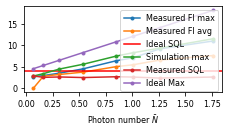

In [9]:
alpha_data_v = {
    '0.5': load_experimental_data('ae/data/2023-11-13_alpha05v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_alpha075v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_alpha1v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-15_alpha125v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-15_alpha15v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-15_alpha175v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),

        # '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '2.1': load_experimental_data('ae/data/2023-11-16_alpha21v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '2.2': load_experimental_data('ae/data/2023-11-16_alpha22v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '2.25': load_experimental_data('ae/data/2023-11-07_alpha225v.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    # '2.3': load_experimental_data('ae/data/2023-11-16_alpha23v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '2.4': load_experimental_data('ae/data/2023-11-16_alpha24v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # '2.5': load_experimental_data('ae/data/2023-11-16_alpha25v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
}

alpha_data_h = {
    '0.5': load_experimental_data('ae/data/2023-11-07_alpha05h.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-07_alpha1h.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-07_alpha15h.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-07_alpha2h.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    # '2.5': load_experimental_data('ae/data/2023-11-07_alpha25h.h5', THRESHOLDS['2023-11-07'], amplitude=True)
}

alpha_sim = {
    '0.5': 'ae/sim/g_0_plus_alpha05_all.npz',
    '0.75': 'ae/sim/g_0_plus_alpha075_all.npz',
    '1': 'ae/sim/g_0_plus_alpha1_all.npz',
    '1.25': 'ae/sim/g_0_plus_alpha125_all.npz',
    '1.5': 'ae/sim/g_0_plus_alpha15_all.npz',
    '1.6': 'ae/sim/g_0_plus_alpha16_all.npz',
    '1.75': 'ae/sim/g_0_plus_alpha175_all.npz',
    '2': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.1': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.2': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.3': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.4': 'ae/sim/g_0_plus_alpha2_all.npz',
    '2.5': 'ae/sim/g_0_plus_alpha2_all.npz',
    # '2.25': 'ae/sim/g_0_plus_alpha225_pm.npz',
    # '2.5': 'ae/sim/g_0_plus_alpha25_pm.npz',
}

# coherent_data = {
#     '0.5': load_experimental_data('ae/data/2023-11-07_c05.h5', THRESHOLDS['2023-11-07'], amplitude=True),
#     '0.75': load_experimental_data('ae/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14'], amplitude=True),
#     '1': load_experimental_data('ae/data/2023-11-07_c1.h5', THRESHOLDS['2023-11-07'], amplitude=True),
#     '1.25': load_experimental_data('ae/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14'], amplitude=True),
#     '1.5': load_experimental_data('ae/data/2023-11-07_c15.h5', THRESHOLDS['2023-11-07'], amplitude=True),
#     '1.6': load_experimental_data('ae/data/2023-11-15_c16.h5', THRESHOLDS['2023-11-15'], amplitude=True),
#     '1.75': load_experimental_data('ae/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14'], amplitude=True),
#     '2': load_experimental_data('ae/data/2023-11-07_c2.h5', THRESHOLDS['2023-11-07'], amplitude=True),
# }

coherent_data = {
    '0.5': load_experimental_data('ae/data/2023-11-07_c05.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_c1.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-07_c15.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-15_c16.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-07_c2.h5', THRESHOLDS['2023-11-07'], amplitude=True),
}

coherent_sim = {
    '0.5': 'ae/sim/g_alpha0258_all.npz',
    '0.75': 'ae/sim/g_alpha04_all.npz',
    '1': 'ae/sim/g_alpha0558_all.npz',
    '1.25': 'ae/sim/g_alpha0732_all.npz',
    '1.5': 'ae/sim/g_alpha0921_all.npz',
    '1.6': 'ae/sim/g_alpha1_all.npz',
    '1.75': 'ae/sim/g_alpha1122_all.npz',
    '2': 'ae/sim/g_alpha1327_all.npz',
}

fig = make_figure()
ax0 = fig.add_subplot(111)

alpha_data = alpha_data_v
MEASURED_SQL = MEASURED_SQL_v

alphas = list(alpha_data.keys())
np_alphas = np.array(alphas, dtype='float')

result_max = []
result_avg = []
result_bandwidth = []
result_th_max = []
# Experimental variance
result_max_var = []
# Bootstrapped sigma
result_sigma = []

result_max_2 = []
result_max_3 = []

result_sim_max = []
result_sim_avg = []
result_sim_bandwidth = []
sim_th_max = []

result_ideal_max = []
result_ideal_bandwidth = []
offset_error_array = []

# Experimental variance
coh_max_var = []
coh_max=[]
# Bootstrapped sigma
coh_sigma = []
coh_sim_max = []
coh_sim_bandwidth = []

for offset in alpha_data:
    data = alpha_data[offset]
    up_lim = 1.6 #np.max(data.x) # 0.1 if (np.max(data.x) < 1.6) else 1.6
    x_dense = np.linspace(np.max([np.min(data.x), 0.01]), up_lim, 2000) #np.linspace(min(d_list), up_lim, 2000)
    # Data fit
    data_fit = np.polyfit(data.x[data.x<=up_lim], data.y[data.x<=up_lim], POLYFIT_ORDER[offset])
    # Experimental FI
    x = x_dense[(x_dense <= up_lim) & (x_dense > 0.0)]
    y_fit = np.poly1d(data_fit)(x)
    # if offset == '2':
    #     idx = x < 1.5
    #     x = x[idx]
    #     y_fit = y_fit[idx]
    m, a, b, mx = extract_FI_params(x, y_fit, MEASURED_SQL[offset])
    dth, _, _ = estimate_delta_theta(data, y_fit, x)
    mu, sigma = compute_many_FI_error(data, x, POLYFIT_ORDER[offset], up_lim, 100)
    _, _, offset_error = compute_many_FI_error_offset(data, x, POLYFIT_ORDER[offset], up_lim, 100)
    result_max.append(m)
    result_avg.append(a)
    offset_error_array.append(offset_error)


    result_bandwidth.append(b)
    result_th_max.append(mx)
    result_max_var.append(1/dth)
    result_sigma.append(sigma[np.argmax(compute_FI(y_fit, x[1]-x[0]))])


    # Simulation FI
    sim = np.load(alpha_sim[offset], 'r')
    d_sim = sim['x']
    p_sim = sim['probability_sim']
    x_sim = d_sim[d_sim <= max(x_dense)]
    y_sim = p_sim[d_sim <= max(x_dense)]
    m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[offset])
    result_sim_max.append(m)
    result_sim_avg.append(a)
    result_sim_bandwidth.append(b)
    sim_th_max.append(mx)

    # Ideal FI
    x = np.linspace(0,2,500) #d_list
    y = ideal_numerical(float(offset), 0.5, x)
    m, a, b, _ = extract_FI_params(x, y, MEASURED_SQL[offset])
    result_ideal_max.append(compute_max_Fq(float(offset)))
    result_ideal_bandwidth.append(b)

    # Classical
    data_c = coherent_data[offset]
    pe_c = data_c.y
    phase_c = data_c.x
    up_lim = np.max(data_c.x)
    data_fit_c = np.polyfit(phase_c[phase_c < up_lim], pe_c[phase_c < up_lim], 5)
    x_dense = np.linspace(min(d_list), up_lim, 2000)
    x = x_dense[(x_dense > 0.05)]
    y_fit_c = np.poly1d(data_fit_c)(x)
    dth, _, _ = estimate_delta_theta(data_c, y_fit_c, x)
    mu, sigma = compute_many_FI_error(data_c, x, 5, up_lim, 100)
    coh_max_var.append(1/dth)
    coh_sigma.append(sigma[np.argmax(compute_FI(y_fit_c, x[1]-x[0])[x<1.7])])
    m, a, b, mx = extract_FI_params(x, y_fit_c, MEASURED_SQL[offset])
    coh_max.append(m)

    # Classical simulation
    sim = np.load(coherent_sim[offset], 'r')
    d_sim = sim['x']
    p_sim = sim['probability_sim']
    x_sim = d_sim[d_sim <= max(x_dense)]
    y_sim = p_sim[d_sim <= max(x_dense)]
    m, a, b, mx = extract_FI_params(x_sim, y_sim, MEASURED_SQL[offset])
    coh_sim_max.append(m)
    coh_sim_bandwidth.append(b)



n = [compute_photon_number(v) for v in np_alphas]

# Fisher information plot
ax0.plot(n, result_max, '.-', label="Measured FI max")
ax0.plot(n, result_avg, '.-', label="Measured FI avg")
ax0.axhline(y=4, color='red', label='Ideal SQL')
ax0.plot(n, result_sim_max, '.-', label="Simulation max")
ax0.plot(n, [MEASURED_SQL_v[alpha] for alpha in alphas], '.-', label="Measured SQL")
ax0.plot(n, [compute_max_Fq(float(alpha)) for alpha in alphas], '.-', label="Ideal Max")
ax0.legend()
# plt.title('Amplitude estimation with balanced cat states') # r'$|0\rangle+|\alpha\rangle$'
ax0.set_xlabel(r"Photon number $\bar{N}$")


In [10]:
offset_error_array

[0.02567177380974319,
 0.018564481802447158,
 0.013674794025521872,
 0.03644173350204096,
 0.015041276205371804,
 0.012539537191253286,
 0.010235233036763897,
 0.07818541888823898]

Variances: var_k = 0.21466511533468222, var_a = 0.015417698347996113, var_c = 0.1281875838506184
Variances: var_k1 = 0.0014159167858983114, var_a1 = 0.020841827670647878, var_c1 = 0.0014159167858983097
Optimized Parameters:
k: 4.959655207348742
a: 1.060104485359565
c: 2.197470765265646
--------------
k1: 0.41116762670899343
a1: 1.8261074812193428e-16
c1: 2.16485423817301


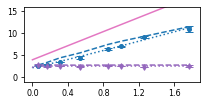

In [21]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


# def fit(avg_num, k, a, c1):
#     return k * avg_num*a + c1

# Define the custom function
def fit(avg_num, k, a, c1):
    return k * avg_num**a + c1


# fig = make_figure()
# ax0 = fig.add_subplot(111)
cm = 0.393701
# fig = plt.subplots(figsize =(3.5*cm, 3.5*cm))
fig = plt.subplots(figsize =(8*cm, 3.5*cm))

# Assuming n and result_max are defined somewhere in your code
x_data = np.array(n)
y_data = np.array(result_max)
y_sql = np.array([MEASURED_SQL[alpha] for alpha in alphas])

# # Use curve_fit to find the parameters that minimize the difference
p0 = [2, 1, 0]
p0_sql = [0.5, 1, 0]
bounds_sql = ([0, 0, 0], [10, 3, 3])

params, covariance = curve_fit(fit, x_data, y_data, p0=p0)
params_sql, covariance_sql = curve_fit(fit, x_data, y_sql, p0=p0_sql, bounds=bounds_sql)


# Params now contains the optimized values for A, B, power1, power2, and c
op_k, op_a, op_c = params
op_k1, op_a1, op_c1 = params_sql

# Create a fitted curve using the optimized parameters
v = np.linspace(0, 1.8, 200)
y_fit = fit(v, op_k, op_a, op_c)
y_sql_fit = fit(v, op_k1, op_a1, op_c1)

# Extract the diagonal elements of the covariance matrix as variances
var_k, var_a, var_c = np.diag(covariance)
print(f"Variances: var_k = {var_k}, var_a = {var_a}, var_c = {var_c}")
var_k1, var_a1, var_c1 = np.diag(covariance_sql)
print(f"Variances: var_k1 = {var_k1}, var_a1 = {var_a1}, var_c1 = {var_c1}")

# Plot the original data and the fitted curve
# ax0.scatter(x_data, y_data, color='tab:blue', marker='*', s=20, label=' SCS')
plt.plot(v, y_fit,  ':', color='tab:blue')
plt.errorbar(x_data, y_data, yerr=result_sigma,  linestyle='', color='tab:blue',  fmt='o', markersize=4, capsize=4, label='SCS')

# ax0.scatter(x_data, y_sql,  color='tab:purple', marker='d'z, s=15, label='classical')
plt.plot(v, y_sql_fit, ':', color='tab:purple')
plt.errorbar(x_data, y_sql, yerr=coh_sigma,  linestyle='', color='tab:purple', fmt='d', markersize=4, capsize=4, label='classical')


plt.plot(n, result_sim_max, '--', color='tab:blue', label='simulation')

plt.plot(n, coh_sim_max, '--', color='tab:purple', label='simulation')

v = np.linspace(0, 2, 200)
plt.plot([compute_photon_number(w) for w in v], [compute_max_Fq(w)
         for w in v], color='tab:pink', label="QFI")


# ax0.legend()
# plt.xlabel(r'Average photon number $\bar{N}$')
# plt.ylabel('Fisher information')
# plt.legend(loc='upper left', fontsize=8)
plt.ylim(-1,16)
tick_start = 0
tick_end = 1.8
tick_step = 0.4
plt.xticks(np.arange(tick_start, tick_end, tick_step))

print("Optimized Parameters:")
print("k:", op_k)
print("a:", op_a)
print("c:", op_c)
print('--------------')
print("k1:", op_k1)
print("a1:", op_a1)
print("c1:", op_c1)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('fig4d.pdf') 

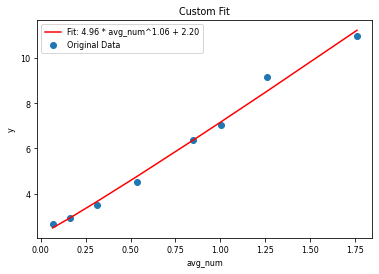

Fitted parameters: k = 4.959655207348742, a = 1.060104485359565, c1 = 2.197470765265646
Variances: var_k = 0.21466511533468222, var_a = 0.015417698347996113, var_c1 = 0.1281875838506184


In [12]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample data
x_data = np.array(n)
y_data = np.array(result_max)

# Define the custom function
def fit(avg_num, k, a, c1):
    return k * avg_num**a + c1

# def fit(avg_num, k, a, c1):
#     return k * avg_num*a + c1

# Use curve_fit to fit the data
params, covariance = curve_fit(fit, x_data, y_data, p0=[2, 1, 0])

# Extract the fitted parameters
k_fit, a_fit, c1_fit = params

# Extract the diagonal elements of the covariance matrix as variances
var_k, var_a, var_c1 = np.diag(covariance)


# Generate fitted y values
y_fit = fit(x_data, k_fit, a_fit, c1_fit)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, label=f'Fit: {k_fit:.2f} * avg_num^{a_fit:.2f} + {c1_fit:.2f}', color='red')
plt.legend()
plt.xlabel('avg_num')
plt.ylabel('y')
plt.title('Custom Fit')
plt.show()

# Print the fitted parameters and their variances
print(f"Fitted parameters: k = {k_fit}, a = {a_fit}, c1 = {c1_fit}")
print(f"Variances: var_k = {var_k}, var_a = {var_a}, var_c1 = {var_c1}")


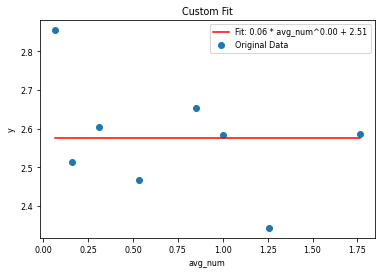

Fitted parameters: k = 0.06335155384149328, a = 5.717002857549937e-16, c1 = 2.512670310748892
Variances: var_k = 262128863123077.7, var_a = 0.9137034520845293, var_c1 = 262128862069396.1


In [13]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample data
x_data = np.array(n)
y_data = np.array(y_sql)

# Define the custom function
def fit(avg_num, k, a, c1):
    return k * avg_num**a + c1



# def fit(avg_num, k, a, c1):
#     return k * avg_num*a + c1

# Use curve_fit to fit the data
params, covariance = curve_fit(fit, x_data, y_data, p0=[0, 0, 2.5], bounds =([0, 0, 0], [1, 3, 2.7]))

# params, covariance = curve_fit(fit, x_data, y_data, p0=[0, 0, 2.5])

# Extract the fitted parameters
k_fit, a_fit, c1_fit = params

# Extract the diagonal elements of the covariance matrix as variances
var_k, var_a, var_c1 = np.diag(covariance)


# Generate fitted y values
y_fit = fit(x_data, k_fit, a_fit, c1_fit)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, label=f'Fit: {k_fit:.2f} * avg_num^{a_fit:.2f} + {c1_fit:.2f}', color='red')
plt.legend()
plt.xlabel('avg_num')
plt.ylabel('y')
plt.title('Custom Fit')
plt.show()

# Print the fitted parameters and their variances
print(f"Fitted parameters: k = {k_fit}, a = {a_fit}, c1 = {c1_fit}")
print(f"Variances: var_k = {var_k}, var_a = {var_a}, var_c1 = {var_c1}")


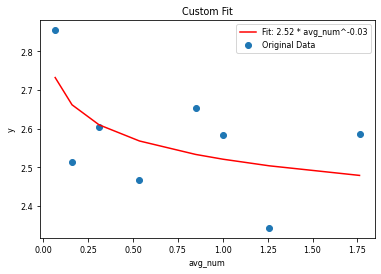

Fitted parameters: k = 2.520775048551401, a = -0.029732177793957162
Variances: var_k = 0.0031522377964908433, var_a = 0.00028349512524002146


In [14]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample data
x_data = np.array(n)
y_data = np.array(y_sql)

# Define the custom function
def fit(avg_num, k, a):
    return k * avg_num**a

# Use curve_fit to fit the data
params, covariance = curve_fit(fit, x_data, y_data, p0=[2.2, 0])

# Extract the fitted parameters
k_fit, a_fit = params

# Extract the diagonal elements of the covariance matrix as variances
var_k, var_a = np.diag(covariance)

# Generate fitted y values
y_fit = fit(x_data, k_fit, a_fit)

# Plot the original data and the fitted curve
plt.scatter(x_data, y_data, label='Original Data')
plt.plot(x_data, y_fit, label=f'Fit: {k_fit:.2f} * avg_num^{a_fit:.2f}', color='red')
plt.legend()
plt.xlabel('avg_num')
plt.ylabel('y')
plt.title('Custom Fit')
plt.show()

# Print the fitted parameters and their variances
print(f"Fitted parameters: k = {k_fit}, a = {a_fit}")
print(f"Variances: var_k = {var_k}, var_a = {var_a}")


Optimized Parameters:
b: 5.088814903979891
a: -0.021515358814149357
c: -4.999999999999998


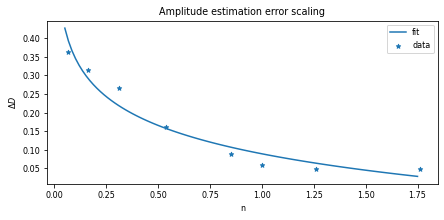

In [15]:
from scipy.optimize import curve_fit


def fit(avg_num, b, a, c):
    return b * avg_num**a + c


params, covariance = curve_fit(
    fit, n, 1/np.array(result_max_var), p0=[1, 0, 0], bounds=([0, -3, -5],[10, 0, 5]))
op_b1, op_a1, op_c1 = params


plt.figure(figsize=(7, 3))
plt.scatter(n, 1/np.array(result_max_var), color='tab:blue',
            marker='*', s=20, label='data')
v = np.linspace(0.05, 1.75, 100)
plt.plot(v, fit(v, op_b1, op_a1, op_c1), color='tab:blue', label='fit')
# plt.plot(v, 1/v, label=r'$\frac{1}{n}$')
plt.xlabel(r'n')
plt.ylabel(r'$\Delta D$')
plt.title('Amplitude estimation error scaling')
# plt.ylabel(r'$\Delta\theta$')
plt.legend()

print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
print("c:", op_c1)

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


var_op_b1: inf
var_op_a1: inf
var_op_c1: inf
var_op_b2: inf
var_op_a2: inf
var_op_c2: inf
Optimized Parameters:
b: -1.310698448420439
a: -0.457899217271606
c: 0.0
---------------
Optimized Parameters:
b: -0.48042643477406727
a: -0.010510104335102655
c: 0.0


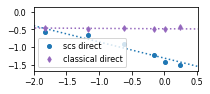

In [16]:
from scipy.optimize import curve_fit


def fit(avg_num, b, a, c):
    return b + avg_num*a

# fig = make_figure(width=8.4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(7.5*cm, 3*cm))

# Assuming n and result_max are defined somewhere in your code
x_data = np.log(n)[1:]
y_data = np.log(result_max)[1:]
y_sql = np.log([MEASURED_SQL[alpha] for alpha in alphas])[1:]

# # Use curve_fit to find the parameters that minimize the difference
params, covariance = curve_fit(fit, x_data, y_data, p0=[4, 2, 0])
params_sql, covariance_sql = curve_fit(fit, x_data, y_sql, p0=[0.5, 1, 0])

# Params now contains the optimized values for A, B, power1, power2, and c
op_b1, op_a1, op_c1 = params
op_b2, op_a2, op_c2 = params_sql

# Create a fitted curve using the optimized parameters
v = np.linspace(-3, 1.8, 200)
y_fit = fit(v, op_b1, op_a1, op_c1)
y_sql_fit = fit(v, op_b2, op_a2, op_c2)

# ax0.scatter(x_data, -0.5*y_data, color='tab:cyan', marker='*', s=20, label='SCS FI')
# ax0.plot(v, -0.5*y_fit,  color='tab:cyan')

# ax0.scatter(x_data, -0.5*y_sql,  color='tab:pink', marker='d', s=15, label='classical FI')
# ax0.plot(v, -0.5*y_sql_fit, color='tab:pink')


# def fit(avg_num, b, a, c):
#     return b * avg_num + a


log_x = np.log(n)[1:]
# log_x = np.log(n)[1:]
# log_y = np.log(np.sqrt(np.array(1/np.array(result_max_var))))[1:]
log_y = np.log(np.sqrt(np.array(1/np.array(result_max_var))))[1:]
params, covariance = curve_fit(fit, log_x, log_y, p0=[1, -1, 0])
op_b1, op_a1, op_c1 = params

var_op_b1,  var_op_a1, var_op_c1 = np.diag(covariance) 
print('var_op_b1:',var_op_b1)
print('var_op_a1:',var_op_a1)
print('var_op_c1:',var_op_c1)

log_y2 = np.log(np.sqrt(np.array(1/np.array(coh_max_var))))[1:]
params, covariance = curve_fit(fit, log_x, log_y2, p0=[1, -1, 0])
# og_y2 = np.log(np.sqrt(np.array(1/np.array(coh_max_var))))[1:]
op_b2, op_a2, op_c2 = params
var_op_b2,  var_op_a2, var_op_c2 = np.diag(covariance) 
print('var_op_b2:', var_op_b2)
print('var_op_a2:', var_op_a2)
print('var_op_c2:', var_op_c2)

plt.plot(log_x, log_y, color='tab:blue', linestyle='', marker='o', markersize=4, label='scs direct')
v = np.linspace(-3, 0.6, 100)
plt.plot(v, fit(v, op_b1, op_a1, op_c1), ':', color='tab:blue')

plt.plot(log_x, log_y2, color='tab:purple', linestyle='', marker='d', markersize=4, label='classical direct')
plt.plot(v, fit(v, op_b2, op_a2, op_c2), ':', color='tab:purple')

# ax0.set_xlabel(r'n')
# ax0.set_ylabel(r'amp')
# ax0.set_title('Amplitude estimation error scaling')
plt.xlim([-2, 0.52])
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel(r'$\Delta\theta$')
plt.legend()
print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
print("c:", op_c1)
print('---------------')
print("Optimized Parameters:")
print("b:", op_b2)
print("a:", op_a2)
print("c:", op_c2)
plt.savefig('amp_direct_measurement.pdf')

In [17]:
alpha_data_v = {
    '0.5': load_experimental_data('ae/data/2023-11-13_alpha05v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_alpha075v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_alpha1v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-15_alpha125v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-15_alpha15v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-15_alpha175v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    # '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
difference_SCS=[]
for name in alpha_data_v:
    data = alpha_data_v[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.3
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # print(max(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # print(idx)
    # print(x_dense[idx])
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x[data.x < up_lim] - x_dense[idx]))
    # print(idx_data)
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)
        
    # mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac)
    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    # opt_p = mu_g_g_vac_boot[idx_data]
    # var_p = np.var(opt_p)
    # print(var_p)
    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )
    
   
    # # theta difference with and without boostraping 

    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2 - var_opt_p / opt_slope**2)) )
    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2)) )
    difference_SCS.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_SCS)


##################################### coherent state ################################

coherent_data = {
    '0.5': load_experimental_data('ae/data/2023-11-07_c05.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_c1.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-07_c15.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-15_c16.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-07_c2.h5', THRESHOLDS['2023-11-07'], amplitude=True),
}

n_boot = 100
difference_coh=[]
for name in coherent_data:
    data = coherent_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x - x_dense[idx]))
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)
        
    # mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac)
    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    # opt_p = mu_g_g_vac_boot[idx_data]
    # var_p = np.var(opt_p)
    # print(var_p)
    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )
    
   
    # # theta difference with and without boostraping 

    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2 - var_opt_p / opt_slope**2)) )
    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2)) )
    difference_coh.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_coh)



[0.0010494282549553893, 0.0054696226652627454, 0.012676003252203779, 0.020882386284900786, 0.015908451465581744, 0.017935747673494214, 0.013081572714001745, 0.012931103896350283]
[0.004310433047938366, 0.0011966354099718778, 0.0023186526725506953, 0.0011014315386359249, 0.0021499058110520885, 0.0015720965309451622, 0.0011882916428273304, 0.002435428387966696]


[[1.45694245e-04 7.90734438e-05]
 [7.90734438e-05 1.85292933e-04]]
Optimized Parameters:
b1: -1.310698448420439
a1: -0.457899217271606
---------------
Optimized Parameters:
b2: -0.48042643477406727
a2: -0.010510104335102655


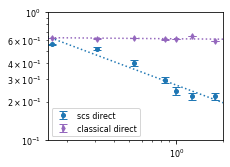

In [18]:
from scipy.optimize import curve_fit


def fit(avg_num, b, a):
    return b + avg_num*a

# fig = make_figure(width=8.4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
cm = 0.393701
fig = plt.subplots(figsize =(8*cm, 6*cm))
# fig = plt.subplots(figsize =(8*cm, 3.5*cm))

# Assuming n and result_max are defined somewhere in your code
x_data = np.log(n)[1:]
y_data = np.log(result_max)[1:]
y_sql = np.log([MEASURED_SQL[alpha] for alpha in alphas])[1:]

# # Use curve_fit to find the parameters that minimize the difference
params, covariance = curve_fit(fit, x_data, y_data, p0=[4, 2])
params_sql, covariance_sql = curve_fit(fit, x_data, y_sql, p0=[0.5, 1])

# Params now contains the optimized values for A, B, power1, power2, and c
op_b1, op_a1 = params
op_b2, op_a2 = params_sql

# Create a fitted curve using the optimized parameters
v = np.linspace(-3, 2, 200)
y_fit = fit(v, op_b1, op_a1)
y_sql_fit = fit(v, op_b2, op_a2)



log_x = np.log(n)[1:]
log_y = np.log(np.sqrt(np.array(1/np.array(result_max_var))))[1:]
params, covariance = curve_fit(fit, log_x, log_y, p0=[1, -1])
op_b1, op_a1 = params
error_SCS = np.array(difference_SCS)[1:]
log_error_SCS = np.log(error_SCS)

log_y2 = np.log(np.sqrt(np.array(1/np.array(coh_max_var))))[1:]
params, covariance_sql = curve_fit(fit, log_x, log_y2, p0=[1, -1])
op_b2, op_a2 = params
error_coh = np.array(difference_coh)[1:]
log_error_coh = np.log(error_coh)
print(covariance_sql)

################ plot ####################

plt.errorbar(np.exp(log_x), np.exp(log_y), yerr=np.exp(log_error_SCS),color='tab:blue', linestyle='', marker='o', markersize=4, capsize =4, label='scs direct')
# plt.plot(np.exp(log_x), np.exp(log_y), color='tab:blue', linestyle='', marker='o', markersize=4, label='scs direct')
v = np.linspace(-3, 1, 100)
plt.plot(np.exp(v), np.exp(fit(v, op_b1, op_a1)), ':', color='tab:blue')

plt.errorbar(np.exp(log_x), np.exp(log_y2), yerr=np.exp(log_error_coh), color='tab:purple', linestyle='', marker='d', markersize=4,capsize=4, label='classical direct')
# plt.plot(np.exp(log_x), np.exp(log_y2), color='tab:purple', linestyle='', marker='d', markersize=4, label='classical direct')
plt.plot(np.exp(v), np.exp(fit(v, op_b2, op_a2)), ':', color='tab:purple')


plt.xlim([0.15, 2])
plt.ylim([1e-1, 1])
plt.yscale('log')
plt.xscale('log')
# plt.ylabel(r'$\Delta\theta$')
plt.legend()
print("Optimized Parameters:")
print("b1:", op_b1)
print("a1:", op_a1)
# print("c:", op_c1)
print('---------------')
print("Optimized Parameters:")
print("b2:", op_b2)
print("a2:", op_a2)
# print("c:", op_c2)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.savefig('sfig3c.pdf')

In [19]:

# Extract the diagonal elements of the covariance matrix as variances
var_op_b1, var_op_a1 = np.diag(covariance)
print(f"Variances: var_op_b1 = {var_op_b1}, var_op_a1 = {var_op_a1}")
var_op_b2, var_op_a2 = np.diag(covariance_sql)
print(f"Variances: var_op_b2 = {var_op_b2}, var_op_a2 = {var_op_a2}")

Variances: var_op_b1 = 0.002265997023227606, var_op_a1 = 0.002881879390968173
Variances: var_op_b2 = 0.0001456942451185394, var_op_a2 = 0.00018529293342388142


In [20]:
var_b, var_a, var_c = np.diag(covariance)
var_b_sql, var_a_sql, var_c_sql = np.diag(covariance_sql)

print('var_b, var_a, var_c:', np.around(var_b,2), np.around(var_a,2), np.around(var_c,2))
print('var_b_sql, var_a_sql, var_c_sql:', np.around(var_b_sql,2), np.around(var_a_sql,2), np.around(var_c_sql,2))


ValueError: not enough values to unpack (expected 3, got 2)

### gain

In [ ]:
A =  np.sqrt(1 / coh_max_var[-2])
B = np.sqrt(1 / result_max_var[-2])
ratio = 20 * np.log10(A / B)
print(ratio)

9.370136568540845


### Error gain propragation $\\$
$gain=20log(\Delta\theta_{SQL}/\Delta\theta_{SCS})-> y=20[log10(a)-log10(b)]$ $\\$
error propragation equation: $\\$
$\Delta y = \sqrt{(\frac{\partial y}{\partial a})^2\Delta a^2 + (\frac{\partial y}{\partial b})^2\Delta b^2}$, therefore, we can get: $\\$
$\frac{\partial y}{\partial a}=20\frac{\partial log10(a)}{\partial a}=\frac{20}{ln(10)a}$, $\frac{\partial y}{\partial b}=20\frac{\partial -log10(b)}{\partial b}=-\frac{20}{ln(10)b}$ $\\$
$\Delta y = \sqrt{(\frac{20}{ln(10)a})^2\Delta a^2 +(\frac{20}{ln(10)b})^2\Delta b^2}$

In [ ]:
d_y = np.sqrt( (20/np.log(10)/np.exp(log_y2[-2]))**2 * difference_coh[-1]**2 + (20/np.log(10)/np.exp(log_y[-2]))**2 * difference_SCS[-1]**2)
print(d_y)

0.5017551194937099


Optimized Parameters:
b: -1.310698448420439
a: -0.457899217271606
c: 0.0
---------------
Optimized Parameters:
b: -0.48042643477406727
a: -0.010510104335102655
c: 0.0


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


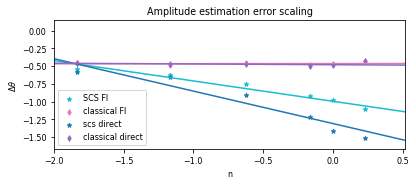

In [ ]:
from scipy.optimize import curve_fit
def fit(avg_num, b, a, c):
    return b + avg_num*a
fig = make_figure(16, 6)
ax0 = fig.add_subplot(111)
# Assuming n and result_max are defined somewhere in your code
x_data = np.log(n)[1:]
y_data = np.log(result_max)[1:]
y_sql = np.log([MEASURED_SQL[alpha] for alpha in alphas])[1:]
# # Use curve_fit to find the parameters that minimize the difference
params, covariance = curve_fit(fit, x_data, y_data, p0=[4, 2, 0])
params_sql, covariance_sql = curve_fit(fit, x_data, y_sql, p0=[0.5, 1, 0])
# Params now contains the optimized values for A, B, power1, power2, and c
op_b1, op_a1, op_c1 = params
op_b2, op_a2, op_c2 = params_sql
# Create a fitted curve using the optimized parameters
v = np.linspace(-3, 1.8, 200)
y_fit = fit(v, op_b1, op_a1, op_c1)
y_sql_fit = fit(v, op_b2, op_a2, op_c2)
ax0.scatter(x_data, -0.5*y_data, color='tab:cyan', marker='*', s=20, label='SCS FI')
ax0.plot(v, -0.5*y_fit,  color='tab:cyan')
ax0.scatter(x_data, -0.5*y_sql,  color='tab:pink', marker='d', s=15, label='classical FI')
ax0.plot(v, -0.5*y_sql_fit, color='tab:pink')
# def fit(avg_num, b, a, c):
#     return b * avg_num + a
log_x = np.log(n)[1:]
log_y = np.log(np.sqrt(np.array(1/np.array(result_max_var))))[1:]
params, covariance = curve_fit(fit, log_x, log_y, p0=[1, -1, 0])
op_b1, op_a1, op_c1 = params
log_y2 = np.log(np.sqrt(np.array(1/np.array(coh_max_var))))[1:]
params, covariance = curve_fit(fit, log_x, log_y2, p0=[1, -1, 0])
op_b2, op_a2, op_c2 = params
ax0.scatter(log_x, log_y, color='tab:blue', marker='*', s=20, label='scs direct')
v = np.linspace(-3, 0.6, 100)
ax0.plot(v, fit(v, op_b1, op_a1, op_c1), color='tab:blue')
ax0.scatter(log_x, log_y2, color='tab:purple', marker='d', s=15, label='classical direct')
ax0.plot(v, fit(v, op_b2, op_a2, op_c2), color='tab:purple')
ax0.set_xlabel(r'n')
ax0.set_ylabel(r'$\Delta\theta$')
ax0.set_title('Amplitude estimation error scaling')
ax0.set_xlim([-2, 0.52])
# plt.yscale('log')
# plt.xscale('log')
# plt.ylabel(r'$\Delta\theta$')
ax0.legend()
print("Optimized Parameters:")
print("b:", op_b1)
print("a:", op_a1)
print("c:", op_c1)
print('---------------')
print("Optimized Parameters:")
print("b:", op_b2)
print("a:", op_a2)
print("c:", op_c2)

### Bandwidth and average

Optimized Parameters:
k: 1.4248175505336493
k: 3.8425758735910307
c: 0.0


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


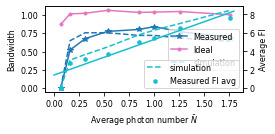

In [ ]:
fig = make_figure()
ax0 = fig.add_subplot(111)
ax1 = ax0.twinx()

# ** Average
# # Use curve_fit to find the parameters that minimize the difference
params, covariance = curve_fit(fit, n, result_avg, p0=[2, 1, 0])
# Params now contains the optimized values for A, B, power1, power2, and c
op_k, op_a, op_c = params
# Create a fitted curve using the optimized parameters
v = np.linspace(0, 1.8, 200)
y_fit = fit(v, op_k, op_a, op_c)
print("Optimized Parameters:")
print("k:", op_k)
print("k:", op_a)
print("c:", op_c)

ax1.scatter(n, result_avg, color='tab:cyan', marker='h', s=15, label="Measured FI avg")
ax1.plot(v, y_fit,  color='tab:cyan')

ax1.plot(n, result_sim_avg, '--', color='tab:cyan', label='simulation')

ax1.set_ylabel('Average FI')

# ** Bandwidth
ax0.plot(n, result_bandwidth, '*-', color='tab:blue', label="Measured")
ax0.plot(n, result_ideal_bandwidth, '.-', color='tab:pink', label="Ideal")

ax0.plot(n, result_sim_bandwidth, '--', color='tab:blue', label='simulation')

# ax0.title('Phase estimation with balanced cat states')
ax0.set_xlabel(r"Average photon number $\bar{N}$")
ax0.set_ylabel("Bandwidth")

ax0.legend(loc='center right')
ax1.legend(loc='lower right')

In [ ]:
alpha_data_v = {
    '0.5': load_experimental_data('ae/data/2023-11-13_alpha05v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_alpha075v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_alpha1v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-15_alpha125v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-15_alpha15v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-15_alpha175v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    # '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
F_avg_error_SCS=[]
var_F_avg_list = []
for name in alpha_data:
    F_avg_array = []
    F_max_array = []
    data = alpha_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)
    for i in range(x_len):
        # First measurement, g
        _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)
    mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac) # shape = (100, 149)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    for k in range(shape(mu_g_g_vac_boot)[0]):
        data_x = data.x
        data_y = mu_g_g_vac_boot[k,:]
        # fit
        data_fit = np.polyfit(data_x[data_x< up_lim], data_y[data_x < up_lim], POLYFIT_ORDER[name])
        y_fit = np.poly1d(data_fit)(x_dense)    
        m, a, _, _ = extract_FI_params(x_dense, y_fit, MEASURED_SQL[name])
        # print(MEASURED_SQL[name])
        # plt.plot(x_dense, y_fit)
        F_avg_array.append(a)
        F_max_array.append(m)
    # print(F_max_array)
    # print(F_avg_array)
    var_F_avg_list.append(np.var(np.array(F_avg_array)))
    # print
F_avg_list_error = np.sqrt(np.array(var_F_avg_list))
print(F_avg_list_error)
print(var_F_avg_list)



[0.28658747 0.04981167 0.05710216 0.19161387 0.13727683 0.08666552
 0.11772738 0.2444219 ]
[0.08213238029899475, 0.002481202577035197, 0.0032606571353841584, 0.03671587698250543, 0.018844928604177892, 0.007510913158101679, 0.013859736778864777, 0.059742063913792845]


3.1533361141855853
1.0000000000000002
2.243654905354927


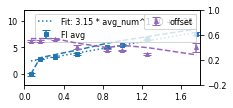

In [ ]:
# cm = 0.393701
# fig = make_figure(width=8*cm, height=8*cm, font_size=8)
# fig = make_figure(width=8, height=8, font_size=8)
cm = 0.393701
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))
# fig, ax0 = plt.subplots(figsize =(3.5*cm, 3.5*cm))
# ax0 = fig.add_subplot(111)
ax1 = ax0.twinx()


# FI avg
ax0.errorbar(n, result_avg,yerr=F_avg_list_error, linestyle='', color='tab:blue', marker='s', markersize=4, capsize=4,label="FI avg")
ax0.plot(n, result_sim_avg, '--', color='tab:blue')
ax0.legend()
ax0.set_xlim(0, 1.8)
ax0.set_ylim(-2,12)
tick_start = 0
tick_end = 1.8
tick_step = 0.4
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))

# Define the custom function
def fit_f_avg(avg_num, b, a, c):
    return b * avg_num**a + c

# def fit_f_avg(avg_num, b, a, c):
#     return b * avg_num + c

# Sample data
x_data = np.array(n[1:])
y_data = np.array(result_avg[1:])

# Use curve_fit to fit the data
lower_bounds = [1, 1, 1.5]
upper_bounds = [5, 1.1, 2.5]
params, covariance = curve_fit(fit_f_avg, x_data, y_data, bounds=(lower_bounds, upper_bounds))
b_fit, a_fit, c_fit = params
y_fit = fit_f_avg(n, b_fit, a_fit, c_fit)

var_b, var_a, var_c = np.diag(covariance)


# Plot the original data and the fitted curve
ax0.plot(n, y_fit, ':',label=f'Fit: {b_fit:.2f} * avg_num^{a_fit:.2f} + {c_fit:.2f}', color='tab:blue')
ax0.legend()

print(b_fit)
print(a_fit)
print(c_fit)


#  offset
ax1.errorbar(n, result_th_max, offset_error_array, linestyle = '',marker='^', markersize=4, color='tab:purple',capsize=4, label="offset")
ax1.plot(n, sim_th_max, '--', color='tab:purple')
ax1.legend()
tick_start = -0.2
tick_end = 1.2
tick_step = 0.4
ax1.set_yticks(np.arange(tick_start, tick_end, tick_step))
plt.savefig('sfig3a.pdf')

In [ ]:
print(var_b, var_a, var_c)

0.21017801423093863 0.027973959043301397 0.14681640586740635


## bandwitdth and FI_avg_above

[0, 0.5209854927463733, 0.6752926463231615, 0.7747173586793397, 0.8009654827413707, 0.839144572286143, 0.7723311655827915, 0.6912006003001502]


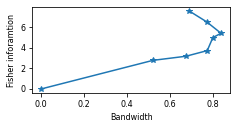

In [ ]:
fig = make_figure()
ax0 = fig.add_subplot(111)
print(result_bandwidth)
ax0.plot(result_bandwidth, result_avg, '*-',  color='tab:blue', label='')
ax0.set_xlabel(r"Bandwidth")
ax0.set_ylabel("Fisher inforamtion")
plt.savefig('FI_avg vs bandwidh.pdf')
# ax0.legend(loc='center right')
# ax1.legend(loc='lower right')

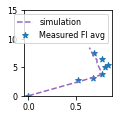

In [ ]:
fig = make_figure(width=4, height=4, font_size=8)
ax0 = fig.add_subplot(111)


ax0.scatter(result_bandwidth, result_avg, color='tab:blue', marker='*', label="Measured FI avg")

ax0.plot(result_sim_bandwidth, result_sim_avg, '--', color='tab:purple', label='simulation')
# ax0.plot(result_ideal_bandwidth, result_ideal_avg, '.-', color='tab:pink', label='Ideal')
ax0.set_ylim(0,15)
# ax0.set_ylabel('Average FI')
# ax0.set_xlabel(r'Bandwidth')
plt.legend()
plt.savefig('amp_FI_avg_bandwidth.pdf')

### $\theta$ offset vs $n$

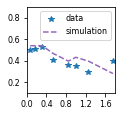

In [ ]:
# n vs theta_max
fig = make_figure(width=4, height=4, font_size=8)
ax0 = fig.add_subplot(111)
ax0.plot(n, result_th_max, '*', color='tab:blue', label='data')
ax0.plot(n, sim_th_max, '--', color='tab:purple', label='simulation')
# ax0.set_xlabel(r'Average photon number $\bar{N}$')
# ax0.set_ylabel(r'Amplitude offset') 
ax0.legend()

tick_start = 0
tick_end = 1.8
tick_step = 0.4
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))
ax0.set_xlim(0,1.8)
ax0.set_ylim(0.1,0.9)
plt.savefig('ampoffset vs N.pdf')

## Unbalanced

### Same n

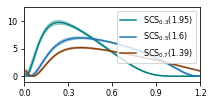

In [ ]:
n1_cat_data = {
    # '0.25': load_experimental_data('pe/data/2023-11-07_025alpha21.h5', THRESHOLDS['2023-11-07']),
    '0.3': load_experimental_data('ae/data/2023-11-14_03alpha195.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '0.4': load_experimental_data('ae/data/2023-11-14_04alpha1745.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '0.5': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '0.6': load_experimental_data('ae/data/2023-11-14_06alpha149.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '0.7': load_experimental_data('ae/data/2023-11-14_07alpha139.h5', THRESHOLDS['2023-11-14'], amplitude=True),

    # '0.8': load_experimental_data('pe/data/2023-11-14_08alpha13.h5', THRESHOLDS['2023-11-14'])
}

SQL_ideal = 4*compute_photon_number(1.6)
SQL_measured = MEASURED_SQL_v['1.6']


# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))


for alpha_coeff in list(n1_cat_data.keys()):
    data = n1_cat_data[alpha_coeff]
    pe = data.y
    phase = data.x

    up_lim = np.max(phase) if (np.max(phase) < 3) else 3
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    # if alpha_coeff == '0.3': order = 5
    # elif  alpha_coeff == '0.25': order = 6
    # else: order = 5
    if alpha_coeff == '0.25':
        order = 6
    elif alpha_coeff == '0.3':
        order = 7
        col = 'teal'#'tab:green'
    elif alpha_coeff == '0.4':
        order = 6
    elif alpha_coeff == '0.5':
        order = 6
        col= 'tab:blue'
    elif alpha_coeff == '0.6':
        order = 5
    elif alpha_coeff == '0.7':
        order = 5
        col = 'saddlebrown'#'tab:orange'
    elif alpha_coeff == '0.8':
        order = 5
    else:
        order = 6

    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Label state (1-x)|0> + x|alpha>
    # state_label = (
    #     txt_sqrt(np.round(1-float(alpha_coeff), 3)) + txt_ket(0) + '+'
    #     + txt_sqrt(alpha_coeff) + txt_ket('\\alpha_{'+alpha_coeff+'}')
    # )
    state_label = name_scs(N1_ALPHA_MAP[alpha_coeff], alpha_coeff, omit05=False)
    # Add to plot
    ax0.plot(x, FI_data, color=col, label=state_label)
    ax0.fill_between(x, mu-sigma, mu+sigma, color=col, alpha=0.3)

# plt.axhline(y=2.48575, color='r', linestyle='--')

# ax0.axhline(y=SQL_measured, color='orange', label='Measured SQL')
# ax0.axhline(y=SQL_ideal, color='red', label='Ideal SQL')
# ax0.set_title("Fisher Information for $n = 1$")
ax0.set_xlim([0, 1.2])
ax0.set_ylim([-1, 12.5])
# ax0.set_ylim([0,2])
# ax0.set_title("Fisher Information for $n = 1$")
# ax0.set_xlabel("Displacement")
# ax0.set_ylabel("Fisher Information")
ax0.legend()
tick_start = 0
tick_end = 1.5
tick_step = 0.3
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))

plt.savefig('sfig4a.pdf')

### Same $\alpha$

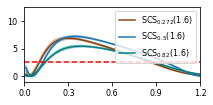

In [ ]:
n1_cat_data = {
    # '0.119': load_experimental_data('ae/data/2023-11-14_0119alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '0.272': load_experimental_data('ae/data/2023-11-14_0272alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '0.5': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    # '0.655': load_experimental_data('ae/data/2023-11-14_0655alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '0.82': load_experimental_data('ae/data/2023-11-14_082alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
}

SQL_ideal = 4*compute_photon_number(1.6)
SQL_measured = MEASURED_SQL_v['1.6']
# fig = make_figure(width=4, height=4, font_size=8)
# ax0 = fig.add_subplot(111)
fig, ax0 = plt.subplots(figsize =(8*cm, 3.5*cm))


for alpha_coeff in list(n1_cat_data.keys()):
    data = n1_cat_data[alpha_coeff]
    pe = data.y
    phase = data.x

    up_lim = np.max(phase) if (np.max(phase) < 3) else 3
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    if alpha_coeff == '0.119':
        order = 5
        col = 'saddlebrown'# 'tab:orange'
    elif alpha_coeff == '0.272':
        order = 7
        col = 'saddlebrown'# 'tab:orange'
    elif alpha_coeff == '0.5':
        order = 5 #POLYFIT_ORDER['1.6']
        col = 'tab:blue'
    elif alpha_coeff == '0.655':
        order = 6
    elif alpha_coeff == '0.82':
        col = 'teal'#'tab:green'
        order = 6
    else:
        order = 4

    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Label state (1-x)|0> + x|alpha>
    # state_label = (
    #     txt_sqrt(np.round(1-float(alpha_coeff), 3)) + txt_ket(0) + '+'
    #     + txt_sqrt(alpha_coeff) + txt_ket('\\alpha = 1.6')
    # )
    state_label = name_scs(1.6, alpha_coeff, omit05=False)
    # Add to plot
    ax0.plot(x, FI_data, color=col, label=state_label)
    ax0.fill_between(x, mu-sigma, mu+sigma, color=col, alpha=0.3)
plt.axhline(y=2.48575, color='r', linestyle='--')
# ax0.set_title(r"Fisher Information for $\alpha = 1.6$")
# ax0.set_xlabel("Displacement")
# ax0.set_ylabel("Fisher information")
ax0.set_xlim([0,1.2])
ax0.set_ylim([-1,12.5])
tick_start = 0
tick_end = 1.5
tick_step = 0.3
ax0.set_xticks(np.arange(tick_start, tick_end, tick_step))
ax0.legend()
plt.savefig('sfig4b.pdf')

# Bootstrapping

IMPORTANT: Bootrapped std is sistematically underestimated. A straight forward way to correct for this is called "balanced bootstrap" and consists of shifting the sampled distribution so that its mean coincides with the observed mean.

In [ ]:
from numpy import sum
from numpy.random import choice


def bootstrap(arr: np.array, n_boot: int = 1000) -> np.array:
    length = len(arr)
    # Mean of the observed data
    mu_obs = np.mean(arr)
    # Mean of the boostrapped samples
    mu_boot = np.zeros(n_boot)
    for i in range(n_boot):
        # Choose random indexes and sample arr
        idx = choice(length, size=length, replace=True)
        samples = arr[idx]
        # Estimate mean
        mu_boot[i] = np.mean(samples)
    # Account for std estimation bias by shifting the distribution to the observed mean
    mu = np.mean(mu_boot)
    mu_boot += mu_obs - mu
    # Estimate std
    sigma = np.std(mu_boot)
    return mu, sigma, mu_boot

In [ ]:
data = load_experimental_data('ae/data/2023-11-16_alpha2_d0j.h5', THRESHOLDS['2023-11-13'], amplitude=True)

# repetitions: shape[0]
# x-axis: shape[1]
mu = np.zeros(data.m1.shape[1])
sigma = np.zeros(data.m1.shape[1])
for i in tqdm(range(data.m1.shape[1])):
    d = np.array(data.m1[:,i], dtype=float)
    mu[i], sigma[i] = bootstrap(d, 100)

plt.errorbar(data.x, mu, yerr=sigma, fmt='o', capsize=5, label='Data with Error Bars')

ValueError: too many values to unpack (expected 2)

  0%|          | 0/151 [00:00<?, ?it/s]

<ErrorbarContainer object of 3 artists>

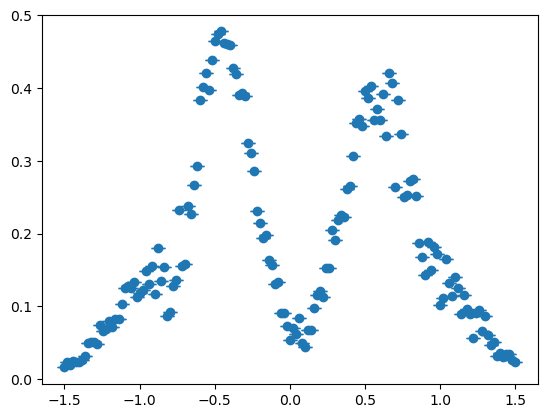

In [ ]:
data = load_experimental_data(
    'ae/data/2023-11-16_alpha2_d0j.h5', THRESHOLDS['2023-11-13'], amplitude=True)

n_boot = 100
x_len = len(data.x)
# repetitions: shape[0]
# x-axis: shape[1]
mu_g = np.zeros(x_len)
mu_gvac = np.zeros(x_len)
sigma_tot = np.zeros(x_len)
for i in tqdm(range(x_len)):
    # First measurement, g
    nan_mask_g = np.isnan(data.m1[:,i])
    mu_g[i], _, mu_boot_g = bootstrap(data.m1[~nan_mask_g, i], 100)

    # Second measurement, g vac
    nan_mask_gvac = np.isnan(data.y_raw[:, i])
    mu_gvac[i], _, mu_boot_gvac = bootstrap(data.y_raw[~nan_mask_gvac, i], 100)

    # Find variance
    cov1 = np.cov(mu_boot_g, mu_boot_gvac)[0, 1]
    cov2 = np.cov(mu_boot_g**2, mu_boot_gvac**2)[0, 1]
    sigma_tot[i] = (
        cov2 + np.mean(mu_boot_g**2)*np.mean(mu_boot_gvac**2) -
        (cov1+np.mean(mu_boot_g)*np.mean(mu_boot_gvac))**2
    )

plt.errorbar(data.x, mu_g*mu_gvac, yerr=sigma_tot, fmt='o',
             capsize=5, label='Data with Error Bars')

Error bar for probability

  0%|          | 0/91 [00:00<?, ?it/s]

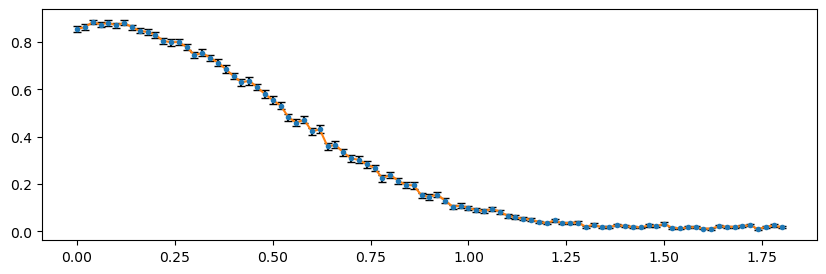

In [ ]:
data = load_experimental_data('ae/data/2023-11-13_alpha15v.h5', THRESHOLDS['2023-11-13'], amplitude=True)

n_boot = 100
x_len = len(data.x)
# repetitions: shape[0]
# x-axis: shape[1]
mu_boot_g = np.zeros([n_boot, x_len])
mu_boot_gvac = np.zeros([n_boot, x_len])
sigma_tot = np.zeros(x_len)
for i in tqdm(range(x_len)):
    # First measurement, g
    _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)

    # Second measurement, g vac
    _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)

    # Find variance
    mu_boot_e = 1-mu_boot_g[:, i]
    cov1 = np.cov(mu_boot_e, mu_boot_gvac[:, i])[0, 1]
    cov2 = np.cov(mu_boot_e**2, mu_boot_gvac[:, i]**2)[0, 1]
    sigma_tot[i] = np.sqrt(
        cov2 + np.mean(mu_boot_e**2)*np.mean(mu_boot_gvac[:, i]**2) -
        (cov1+np.mean(mu_boot_e)*np.mean(mu_boot_gvac[:, i]))**2
    )

mu = np.mean(1-mu_boot_g, 0) * np.mean(mu_boot_gvac, 0)
plt.figure(figsize=(10,3))
plt.errorbar(data.x, mu, yerr=sigma_tot, fmt='.', capsize=3, ecolor='black')
plt.plot(data.x, data.y)

Error bar for FI computing many FIs

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

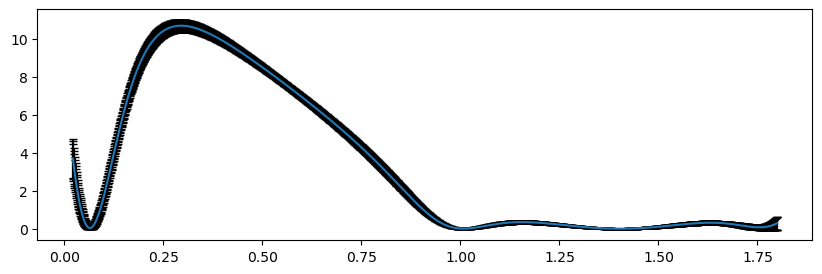

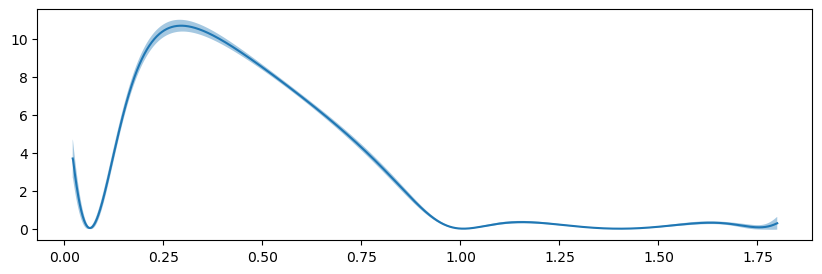

In [ ]:
alpha = 2
data = load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True)

n_boot = 1000
x_len = len(data.x)
# repetitions: shape[0]
# x-axis: shape[1]
mu_boot_g = np.zeros([n_boot, x_len])
mu_boot_gvac = np.zeros([n_boot, x_len])
sigma_tot = np.zeros(x_len)
for i in tqdm(range(x_len)):
    # First measurement, g
    _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)

    # Second measurement, g vac
    _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)


up_lim_v = np.max(data.x)
x_dense = np.linspace(min(d_list), up_lim_v, 2000)
x = x_dense[(x_dense > 0.02)]
FIs = np.zeros([n_boot, len(x)])
for i in tqdm(range(n_boot)):
    mu = (1-mu_boot_g[i,:]) * mu_boot_gvac[i,:]

    data_fit_v = np.polyfit(data.x, mu, POLYFIT_ORDER[str(alpha)])

    # Fisher information
    y_fit = np.poly1d(data_fit_v)(x)
    FIs[i,:] = compute_FI(y_fit, x[1] - x[0])

plt.figure(figsize=(10,3))
plt.errorbar(x, np.mean(FIs, axis=0), yerr=np.std(FIs, axis=0), fmt='-', capsize=3, ecolor='black')

plt.figure(figsize=(10,3))
FI = np.mean(FIs, axis=0)
sFI = np.std(FIs, axis=0)
plt.fill_between(x, FI-sFI, FI+sFI, alpha=0.4)
plt.plot(x, FI)

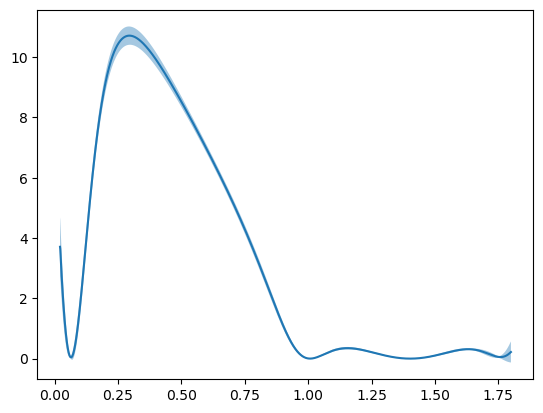

In [ ]:
FI = np.mean(FIs, axis=0)
sFI = np.std(FIs, axis=0)
plt.fill_between(x, FI-sFI, FI+sFI, alpha = 0.4)
plt.plot(x,FI)

  0%|          | 0/181 [00:00<?, ?it/s]

1.599799899949975

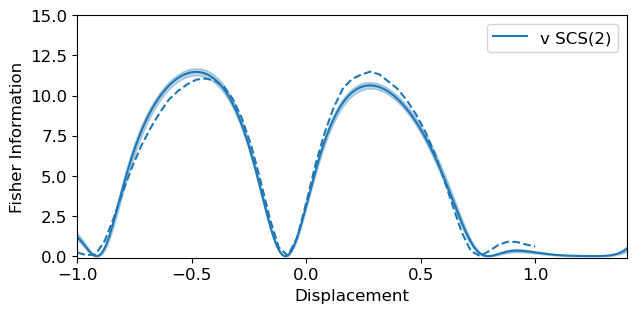

In [ ]:
data_list = {
    # 'c2': load_experimental_data('ae/data/2023-11-13_c2.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    # 'h2': load_experimental_data('ae/data/2023-11-21_alpha2h.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
}

sim_list = {
    '2': 'ae/sim/g_0_plus_alpha2_all.npz',
    'c2': 'ae/sim/g_alpha1327_all.npz',
    'h2': 'ae/sim/g_0_plus_alpha2_all_h.npz',
}

colors = {
    # 'c2': ['tab:purple', 'tab:pink'],
    # '2': ['tab:blue', 'tab:cyan'],
    'c2': ['tab:purple', 'tab:purple'],
    '2': ['tab:blue', 'tab:blue'],
    'h2': ['tab:gray', 'tab:brown']
}

fig = make_figure()
ax0 = fig.add_subplot(111)

for name in list(data_list.keys()):
    data = data_list[name]
    pe = data.y
    phase = data.x

    up_lim = 1.6  # if float(alpha) > 1 else np.max(data.x) - 0.1
    x = np.linspace(-1, up_lim, 2000)

    if name[0] == 'c':
        order = 5
    elif name[0] == 'h':
        order = 6
    elif name == '2':
        order = 12
    else:
        order = POLYFIT_ORDER[name]
    # Data
    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])

    # Simulation
    if not (name in sim_list):
        continue
    sim = np.load(sim_list[name], 'r')
    phase_sim = sim['x']
    pe_sim = sim['probability_sim']
    if name[0] == 'h':
        phase_sim = phase_sim * 1j*1j*1j
    x_sim = phase_sim[phase_sim <= max(x)]
    y_sim = pe_sim[phase_sim <= max(x)]
    FI_sim = compute_FI(y_sim, x_sim[1]-x_sim[0])

    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Add plots
    if colors[name]:
        col = colors[name]
    else:
        col = [None, None]

    if name[0] == '2':
        lab = 'v ' + name_scs(2)  # + txt_ket(0) + '+' + txt_ket(r"\alpha = 2")
    elif name[0] == 'c':
        lab = name_scs(COH_MAP['2'])  # 'classical'
    elif name[0] == 'h':
        lab = 'h ' + name_scs(2)  # + txt_ket(0) + '+' + txt_ket(r"\alpha = 2")
    ax0.plot(x_sim, FI_sim, '--', markersize=3, color=col[1])
    ax0.plot(x, FI_data, color=col[0], label=lab)
    ax0.fill_between(x, mu-sigma, mu+sigma, color=col[0], alpha=0.3)

ax0.set_xlim([-1, 1.4])
ax0.set_ylim([-0.1, 15])
# ax0.set_title("Fisher Information for $n = 1$")
ax0.set_xlabel("Displacement")
ax0.set_ylabel("Fisher Information")
ax0.legend()


m, a, b, mx = extract_FI_params(x, y_fit, MEASURED_SQL_v['2'])
b


  max:  4.709 --> 1.822
  average: 3.983 --> 1.541
  bandwitdth: 0.766




  max:  1.676 --> 0.648




  max:  528.599 --> 204.514
  average: 7.166 --> 2.772
  bandwitdth: 1.419




  max:  2.727 --> 1.055
  average: 2.679 --> 1.037
  bandwitdth: 0.274



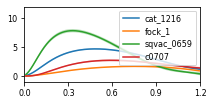

In [ ]:
n1_cat_data = {
    'cat_1216': load_experimental_data('ae/data/2023-12-06_g_alpha1216_v.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    'fock_1': load_experimental_data('ae/data/2023-12-06_g_fock1_v.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    'sqvac_0659': load_experimental_data('ae/data/2023-12-06_g_sqvac_h.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    'c0707': load_experimental_data('ae/data/2023-12-06_g_c0707_v.h5', THRESHOLDS['2023-12-06'], amplitude=True),
    }

SQL_ideal = 4*compute_photon_number(1.6)
SQL_measured = MEASURED_SQL_v['1.6']


# fig1 = make_figure()
# ax1 = fig1.add_subplot(111)

# fig2 = make_figure(width=4, height=4, font_size=8)
# ax2 = fig2.add_subplot(111)

cm = 0.393701
fig, ax2 = plt.subplots(figsize =(8*cm, 3.5*cm))
# fig, ax2 = plt.subplots(figsize =(3.5*cm, 3.5*cm))

for state in list(n1_cat_data.keys()):
    data = n1_cat_data[state]
    pe = data.y
    phase = data.x

    up_lim = np.max(phase) if (np.max(phase) < 3) else 3
    x = np.linspace(np.max([np.min(phase), 0.01]), up_lim, 2000)

    if state == 'cat_1216':
        order = 8
    elif state == 'fock_1':
        order = 5
    elif state == 'sqvac_0659':
        order = 13
    else:
        order = 10

    data_fit = np.polyfit(phase[phase < up_lim], pe[phase < up_lim], order)
    y_fit = np.poly1d(data_fit)(x)
    FI_data = compute_FI(y_fit, x[1] - x[0])
    mu, sigma = compute_many_FI_error(data, x, order, up_lim, 100)

    # Label state (1-x)|0> + x|alpha>
    state_label = state
    # Add to plot
    # ax1.plot(phase, pe, ".-", label=state_label)

    # label=f'Fit {alphaCoeff}' + r'$|0\rangle$+' + f'{np.round(1-float(alphaCoeff),1)}' + r'$|\alpha\rangle$'
    # ax1.plot(x, y_fit)
    ax2.plot(x[x<1.2], FI_data[x<1.2], label=state_label)
    ax2.fill_between(x[x<1.2], mu[x<1.2]-sigma[x<1.2], mu[x<1.2]+sigma[x<1.2], alpha=0.3)

    # print(f'{np.round(1-float(alpha_coeff),1)} |0> + {alpha_coeff} |alpha>')
    print_FI(x, FI_data, SQL_measured, ' ')
    print('')

    

    # np.savez(f'processed/phase_unbalanced_{alpha_coeff}.npz',
    #     # Data
    #     x_data=phase,
    #     y_data=data.y,
    #     x_fit=x,
    #     y_fit=y_fit,
    #     FI_data=FI_data
    # )

# ax1.legend()
# ax1.set_xlabel("Displacement")
# ax1.set_ylabel(r'$P_{|g0\rangle}$')
# ax1.set_title(r'Phase estimation for $\alpha = 1.6$')

# ax2.axhline(y=SQL_measured, color='orange', label='Measured SQL')
# ax2.axhline(y=SQL_ideal, color='red', label='Ideal SQL')
# ax2.set_title(r"Fisher Information for $\alpha = 1.6$")
# ax2.set_xlabel("Displacement")
# ax2.set_ylabel("Fisher information")
ax2.legend()
tick_start = 0
tick_end = 1.5
tick_step = 0.3
ax2.set_xticks(np.arange(tick_start, tick_end, tick_step))
ax2.set_ylim(-1,12)
ax2.set_xlim(0, 1.2)
plt.savefig('sfig2b.pdf')

In [ ]:
alpha_data_v = {
    '0.5': load_experimental_data('ae/data/2023-11-13_alpha05v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_alpha075v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_alpha1v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-15_alpha125v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-15_alpha15v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-15_alpha175v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    # '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
difference_SCS=[]
for name in alpha_data_v:
    data = alpha_data_v[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.3
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # print(max(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # print(idx)
    # print(x_dense[idx])
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x[data.x < up_lim] - x_dense[idx]))
    # print(idx_data)
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)
        
    # mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac)
    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    # opt_p = mu_g_g_vac_boot[idx_data]
    # var_p = np.var(opt_p)
    # print(var_p)
    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )
    
   
    # # theta difference with and without boostraping 

    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2 - var_opt_p / opt_slope**2)) )
    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2)) )
    difference_SCS.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_SCS)


##################################### coherent state ################################

coherent_data = {
    '0.5': load_experimental_data('ae/data/2023-11-07_c05.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_c1.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-07_c15.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-15_c16.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-07_c2.h5', THRESHOLDS['2023-11-07'], amplitude=True),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# # ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
difference_coh=[]
for name in coherent_data:
    data = coherent_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x - x_dense[idx]))
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)
        
    # mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac)
    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    # opt_p = mu_g_g_vac_boot[idx_data]
    # var_p = np.var(opt_p)
    # print(var_p)
    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )
    
   
    # # theta difference with and without boostraping 

    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2 - var_opt_p / opt_slope**2)) )
    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2)) )
    difference_coh.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_coh)



[0.001092058796684168, 0.005623556550089184, 0.01270808100036272, 0.020216487686300227, 0.01594309922798177, 0.018207996609708177, 0.012702614467204922, 0.013288142886084424]


In [ ]:
coherent_data = {
    '0.5': load_experimental_data('ae/data/2023-11-07_c05.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_c075.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_c1.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-14_c125.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-07_c15.h5', THRESHOLDS['2023-11-07'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-15_c16.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-14_c175.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-07_c2.h5', THRESHOLDS['2023-11-07'], amplitude=True),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# # ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
difference_coh=[]
for name in coherent_data:
    data = coherent_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    data_fit = np.polyfit(data.x[data.x < up_lim], data.y[data.x < up_lim], POLYFIT_ORDER[name])
    y_fit = np.poly1d(data_fit)(x_dense)
    FI = compute_FI(y_fit, x_dense[1]-x_dense[0])
    # print(len(FI))
    # Get the optimal point from fitting data
    idx = np.argmax(FI)
    # Index for experimental data
    idx_data = np.argmin(np.abs(data.x - x_dense[idx]))
    opt_slope = np.gradient(y_fit, x_dense[1]-x_dense[0])[idx]
    
    # # Get optimal data
    m1 = data.m1
    mx_g = data.y_raw
    opt_p_g = 1 - m1[:, idx_data]
    opt_p_gvac = mx_g[:, idx_data]
    var_opt_p = np.var(opt_p_g * opt_p_gvac)

    for i in range(x_len):
        # First measurement, g
        # _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)
        _, _, mu_boot_g[:,i], mu_boot_g_dp[:,i] = bootstrap_dp(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i], mu_boot_gvac_dp[:,i] = bootstrap_dp(data.y_raw[:, i], n_boot)
        
    # mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac)
    mu_g_g_vac_boot_dp = mu_boot_g_dp * mu_boot_gvac_dp

    # opt_p = mu_g_g_vac_boot[idx_data]
    # var_p = np.var(opt_p)
    # print(var_p)
    var_mu_g_g_vac_boot_dp  = np.var( mu_g_g_vac_boot_dp[idx_data] )
    
   
    # # theta difference with and without boostraping 

    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2 - var_opt_p / opt_slope**2)) )
    # difference_SCS.append(  np.sqrt(abs(var_p / opt_slope**2)) )
    difference_coh.append( np.sqrt(var_mu_g_g_vac_boot_dp) )
 

print(difference_coh)


[0.0035436049562557535, 0.0010510087075410763, 0.002373811432229588, 0.001184424005699749, 0.0020608909176388613, 0.0015216645007758024, 0.0011063943351961754, 0.002007488547282707]


In [ ]:
alpha_data_v = {
    '0.5': load_experimental_data('ae/data/2023-11-13_alpha05v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '0.75': load_experimental_data('ae/data/2023-11-14_alpha075v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1': load_experimental_data('ae/data/2023-11-13_alpha1v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '1.25': load_experimental_data('ae/data/2023-11-15_alpha125v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.5': load_experimental_data('ae/data/2023-11-15_alpha15v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    '1.6': load_experimental_data('ae/data/2023-11-14_alpha16.h5', THRESHOLDS['2023-11-14'], amplitude=True),
    '1.75': load_experimental_data('ae/data/2023-11-15_alpha175v.h5', THRESHOLDS['2023-11-15'], amplitude=True),
    # '2': load_experimental_data('ae/data/2023-11-24_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
    '2': load_experimental_data('ae/data/2023-11-13_alpha2v.h5', THRESHOLDS['2023-11-13'], amplitude=True),
}

# cm = 0.393701
# fig = plt.subplots(figsize =(8*cm, 5.5*cm))
# ax0 = fig.add_subplot(111)
n_boot = 100
# colors = {
#     'SCS': ['tab:blue', 'o'],
#     'SQL': ['tab:purple', 'd'],
# }
F_avg_error_SCS=[]
var_F_avg_list = []
for name in alpha_data:
    F_avg_array = []
    F_max_array = []
    data = alpha_data[name]
    x_len = len(data.x)
    mu_boot_g = np.zeros([n_boot, x_len])
    mu_boot_g_dp = np.zeros([n_boot, x_len])
    mu_boot_gvac = np.zeros([n_boot, x_len])
    mu_boot_gvac_dp = np.zeros([n_boot, x_len])
    sigma_tot = np.zeros(x_len)
    for i in range(x_len):
        # First measurement, g
        _, _, mu_boot_g[:,i] = bootstrap(data.m1[:, i], n_boot)

        # Second measurement, g vac
        _, _, mu_boot_gvac[:, i] = bootstrap(data.y_raw[:, i], n_boot)
    mu_g_g_vac_boot = (1-mu_boot_g) * (mu_boot_gvac) # shape = (100, 149)

    # scs 
    up_lim = 1.6
    x_dense = np.linspace(0, up_lim, 2000)
    # data fit
    for k in range(shape(mu_g_g_vac_boot)[0]):
        data_x = data.x
        data_y = mu_g_g_vac_boot[k,:]
        # fit
        data_fit = np.polyfit(data_x[data_x< up_lim], data_y[data_x < up_lim], POLYFIT_ORDER[name])
        y_fit = np.poly1d(data_fit)(x_dense)    
        m, a, _, _ = extract_FI_params(x_dense, y_fit, MEASURED_SQL[name])
        # print(MEASURED_SQL[name])
        # plt.plot(x_dense, y_fit)
        F_avg_array.append(a)
        F_max_array.append(m)
    # print(F_max_array)
    # print(F_avg_array)
    var_F_avg_list.append(np.var(np.array(F_avg_array)))
    # print
F_avg_list_error = np.sqrt(np.array(var_F_avg_list))
print(F_avg_list_error)
print(var_F_avg_list)



[0.28531615 0.05026906 0.05579063 0.17217627 0.29810328 0.09511148
 0.11339077 0.26238142]
[0.08140530481111904, 0.002526978080281794, 0.0031125939235239404, 0.02964466862464805, 0.08886556455267808, 0.009046194540612616, 0.01285746776524097, 0.06884401067623283]


In [ ]:
print(result_avg)

[0, 2.7818646404063405, 3.1842457863283604, 3.7325371327403927, 5.009590249954178, 5.418998922192822, 6.53152869992398, 7.584604174348943]
